# Non-stationary SGS with k-means clustering

Often you may encounter an environment where the spatial statistics are not uniform throughout a region. This is known as non-stationarity. For example, topography can be rough in some places but smooth in others. Here, we demonstrate how to implement SGS with multiple variograms assigned to different regions. We use k-means clustering to divide the data into clusters, and model a separate variogram for each cluster.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs
from sklearn.cluster import KMeans

## Load and plot data

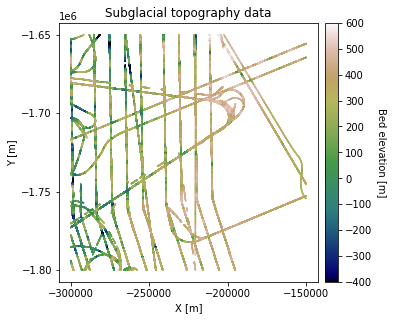

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

## Grid and transform data

In [3]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

## Group data into different clusters using K-means clustering

We will break the data into different groups so that each group can be assigned a different variogram. There are many ways the data could be divided. Here we will use k-means clustering with three clusters. The clustering will be based on the coordinates and bed elevation values of the data. The intuition is that data points in similar locations with similar elevation ranges are more likely to have similar variogram parameters.

In [4]:
# K means clustering
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(df_grid[['X','Y','Nbed']])
df_grid['K'] = kmeans.labels_  # make column in dataframe with cluster name

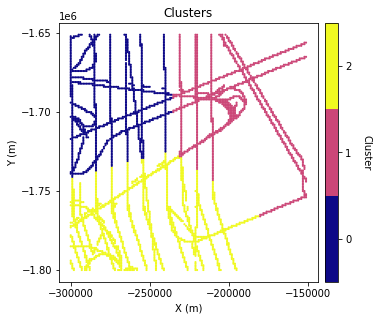

In [5]:
cmap = plt.get_cmap('plasma', n_clusters)

plt.figure(figsize=(5,5))
im = plt.scatter(df_grid['X'],df_grid['Y'], c=df_grid['K'], marker=".", s = 5, cmap=cmap)
im.set_clim(-0.5, n_clusters-0.5)
plt.title('Clusters')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.locator_params(nbins=5)

# make colorbar
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_ticks(np.linspace(0, n_clusters-1, n_clusters))
cbar.set_ticklabels(range(n_clusters))
cbar.set_label('Cluster', rotation=270, labelpad=20)

ax.axis('scaled')
plt.show()

In [6]:
# experimental variogram parameters
maxlag = 50000
n_lags = 70 #num of bins

# cluster 0 variogram
df0 = df_grid[df_grid['K'] == 0]
coords0 = df0[['X','Y']].values
values0 = df0['Nbed']
V0 = skg.Variogram(coords0, values0, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)


# cluster 1 variogram
df1 = df_grid[df_grid['K'] == 1]
coords1 = df1[['X','Y']].values
values1 = df1['Nbed']
V1 = skg.Variogram(coords1, values1, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)


# cluster 2 variogram
df2 = df_grid[df_grid['K'] == 2]
coords2 = df2[['X','Y']].values
values2 = df2['Nbed']
V2 = skg.Variogram(coords2, values2, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False) 

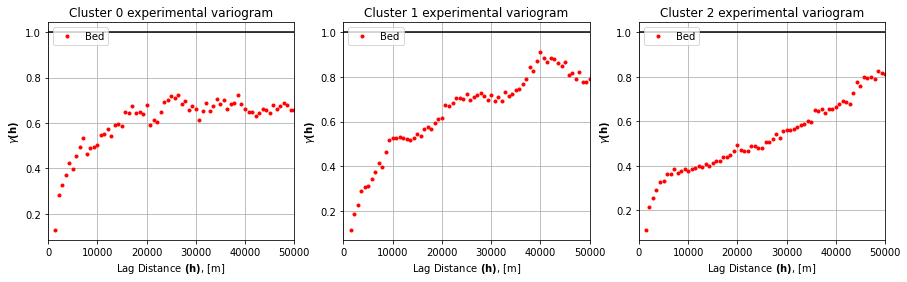

In [7]:
variograms = [V0, V1, V2]

fig, axs = plt.subplots(1, 3, figsize=(15,4))

for i, (ax, V) in enumerate(zip(axs, variograms)):
    ax.plot(V.bins,V.experimental,'.',color = 'red',label = 'Bed')
    ax.hlines(y=1.0, xmin=0, xmax=50_000, color='black')
    ax.set_xlabel(r'Lag Distance $\bf(h)$, [m]')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {i} experimental variogram')
    ax.legend(loc='upper left')
    ax.set_xlim([0,50_000])
    ax.grid(True)
    
plt.show()

In [8]:
# fit variogram model
# use exponential variogram model
V0.model = 'exponential' 
V1.model = 'exponential' 
V2.model = 'exponential' 

# create array of evenly spaced lag values to evaluate
n = 100
lagh = np.linspace(0,30000,n)

range0 = V0.parameters[0]; sill0 = V0.parameters[1]
range1 = V1.parameters[0]; sill1 = V1.parameters[1]
range2 = V2.parameters[0]; sill2 = V2.parameters[1]

y0 = [models.exponential(h, range0, sill0, 0) for h in lagh]
y1 = [models.exponential(h, range1, sill1, 0) for h in lagh]
y2 = [models.exponential(h, range2, sill2, 0) for h in lagh]

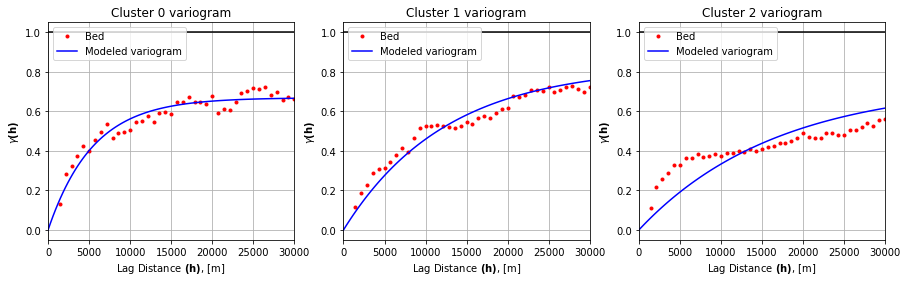

In [9]:
variograms = [V0, V1, V2]
ys = [y0, y1, y2]

fig, axs = plt.subplots(1, 3, figsize=(15,4))

for i, (ax, V, y) in enumerate(zip(axs, variograms, ys)):
    ax.plot(V.bins, V.experimental, '.', color='red', label='Bed')
    ax.plot(lagh, y, '-', color='blue', label='Modeled variogram')
    ax.hlines(y=1.0, xmin=0, xmax=30_000, color='black')
    ax.set_xlabel(r'Lag Distance $\bf(h)$, [m]')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {i} variogram')
    ax.legend(loc='upper left')
    ax.set_xlim([0,30_000])
    ax.grid(True)
    
plt.show()

## Simulate with SGS

Next we will implement SGS with multiple variograms. This function is very similar to the original SGS. However, each time a grid cell is simulated, the nearest neighbor k-cluster value is used to select the variogram that is used for that point. This is done as follows:

For each grid cell in a random path:
1. Find the nearest neighbors in the conditioning data, and determine which cluster the nearest point belongs to.
2. Look up the variogram parameters associated with that cluster.
3. Use simple kriging to estimate the mean and variance.
4. Sample from the distribution defined by the mean and variance. This is the simulated value.
5. Append the simulated value to the conditioning data, and give it the same cluster number that was found in Step 2.
6. Repeat steps 1-5 until every grid cell is simulated.

Note that the SGS clustering function (cluster_SGS) uses simple kriging. There is no ordinary kriging option.

In [10]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [11]:
# make a list with variogram parameters
azimuth = 0

# nugget effect
nug = 0 

# variogram model
vtype = 'Exponential'

# define variograms for each cluster
# Azimuth, nugget, major range, minor range, sill
gam0 = [azimuth, nug, range0, range0, sill0, vtype]
gam1 = [azimuth, nug, range1, range1, sill1, vtype]
gam2 = [azimuth, nug, range2, range2, sill2, vtype]

# store variogram parameters
df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2]})

In [12]:
# simulate

k = 100            # number of neighboring data points used to estimate a given point 
rad = 50000        # 50 km search radius

sgs = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
sgs = sgs.reshape(-1,1)
sgs_trans = nst_trans.inverse_transform(sgs)

100%|█████████████████████████████████████| 22500/22500 [04:39<00:00, 80.53it/s]


Make hillshade plot

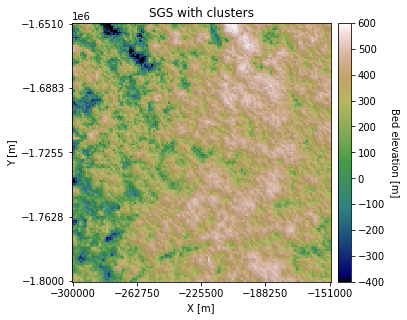

In [13]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sgs_trans.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS with clusters')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

You can see that some regions appear rougher than others. We can also change the Azimuth and anisotropy in different clusters:

In [14]:
# simulation demo #2

# define variograms for each cluster
gam0 = [45, nug, range0  + 15000, range0, sill0, vtype]                  # create anisotropy
gam1 = [azimuth, nug, range1, range1, .6, vtype]                     # change the sill
gam2 = [90, nug, range2 + 15000, range2, sill2, vtype]                   # create anisotropy
df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2]})    # store variogram parameters

sgs2 = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
sgs2 = sgs2.reshape(-1,1)
sgs2_trans = nst_trans.inverse_transform(sgs2)

100%|█████████████████████████████████████| 22500/22500 [04:52<00:00, 76.86it/s]


Make hillshade plot

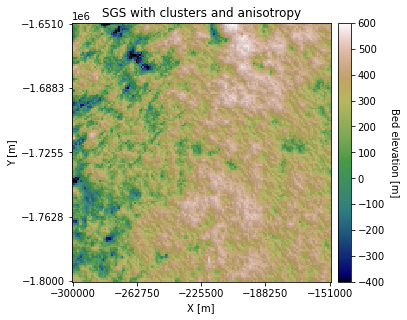

In [15]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sgs2_trans.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS with clusters and anisotropy')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

There are some visible differences in the topography orientation.

Download the tutorial {Download}`here<./7_non-stationary_SGS_example1.ipynb>`.